# Import Libraries and Data

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, cohen_kappa_score, log_loss,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc)
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Reset Plot Settings
plt.rcdefaults()

In [126]:
df_red = pd.read_csv('wine_red.csv')
df_white = pd.read_csv('wine_white.csv')

## Printing First 5 Rows of the Data

In [128]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [129]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


# Data Pre-Processing

Our goal is to make accurate predictions of color of the wine in the data set. **We are not choosing to predict the quality of the wine (as suggested and provided) as this is quality to whoever rated the wine and there is also the potential that these factors already were used to determine the quality of the wine itself.**

This data set was sourced from the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/186/wine+quality

Since we are calculating the color of the wine (red or white), we are performing a classification task. All of the predictors are numeric and these predictors represent the amount of various chemicals present in the wine. There are 6497 records and up to 11 features we could use to make predictions.

**Note:** This data set is limited in scope to red variants of the Portuguese "Vinho Verde" wine. This wine comes from a specific region, follows a common production method, and comes from a limited set of grape varietals. More information is here: https://en.wikipedia.org/wiki/Vinho_Verde

To begin, we will join the red wine and white wine data sets together. **There are significantly fewer records for red wine, so this may cause performance issues related to an imbalanced data set down the line.**

In [133]:
df = pd.concat([df_red, df_white])

Next, we will go ahead and drop quality from the data set, as this intuitively should not be used to make predictions about the wine color.

In [135]:
df.drop(columns=['quality'], inplace = True)

Next, we will drop any duplicate rows. This drops us from 6497 rows to 5320 rows.

In [137]:
print(df.shape)
df.drop_duplicates(keep='first', inplace = True)
print(df.shape)

(6497, 12)
(5320, 12)


In [138]:
# Checking for Null Values
print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
color                   0
dtype: int64


There are no null values in the data set! This saves us a lot of time from having to either remove these rows or imputate these values. It is also unlikely that zero-values are masquerading as null values in this data set.

Next, we want to make sure that the data is in the proper format for modeleing purposes in Scikit-Learn. Based on the results below, we only need to make the target variable, color, categorical and binary.

In [141]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
color                    object
dtype: object

In [142]:
df['color'].astype('category')
df = pd.get_dummies(df, drop_first=True)
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
color_white                bool
dtype: object

**So, the interpretation is that if color_white is false, the color of the wine is red! In other words, 0 corresponds to red wine, 1 corresponds to white wine.**

Next, we wanted to measure how our numerical features correlate with the target variable.

In [145]:
def correlation_analysis(df, target):
    correlation_matrix = df.corr()
    correlation_with_target = correlation_matrix[target].sort_values(ascending=False)
    print("Correlation with Target Variable:")
    print(correlation_with_target)

correlation_analysis(df, 'color_white')

Correlation with Target Variable:
color_white             1.000000
total sulfur dioxide    0.694229
free sulfur dioxide     0.465326
residual sugar          0.328695
citric acid             0.183759
alcohol                 0.057756
pH                     -0.310919
density                -0.429377
fixed acidity          -0.486253
sulphates              -0.490364
chlorides              -0.499517
volatile acidity       -0.645335
Name: color_white, dtype: float64


As seen above, high sulfur dioxide, residual sugar, and citric seem to correspond to white wine more often than not, and higher acidity, chlorides, sulphaes, density, and pH are more associated with non-white wines (in this case, red wine).

Finally, next want to see if scaling the data is necessary by seeing if our predictors have different ranges since we plan to use algorithms that are sensitive to feature scaling, such as logistic regression and k-nearest neighbors. To do this, we inspected the summary statistics of our dataset and visualize the ranges of the different features.

In [148]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


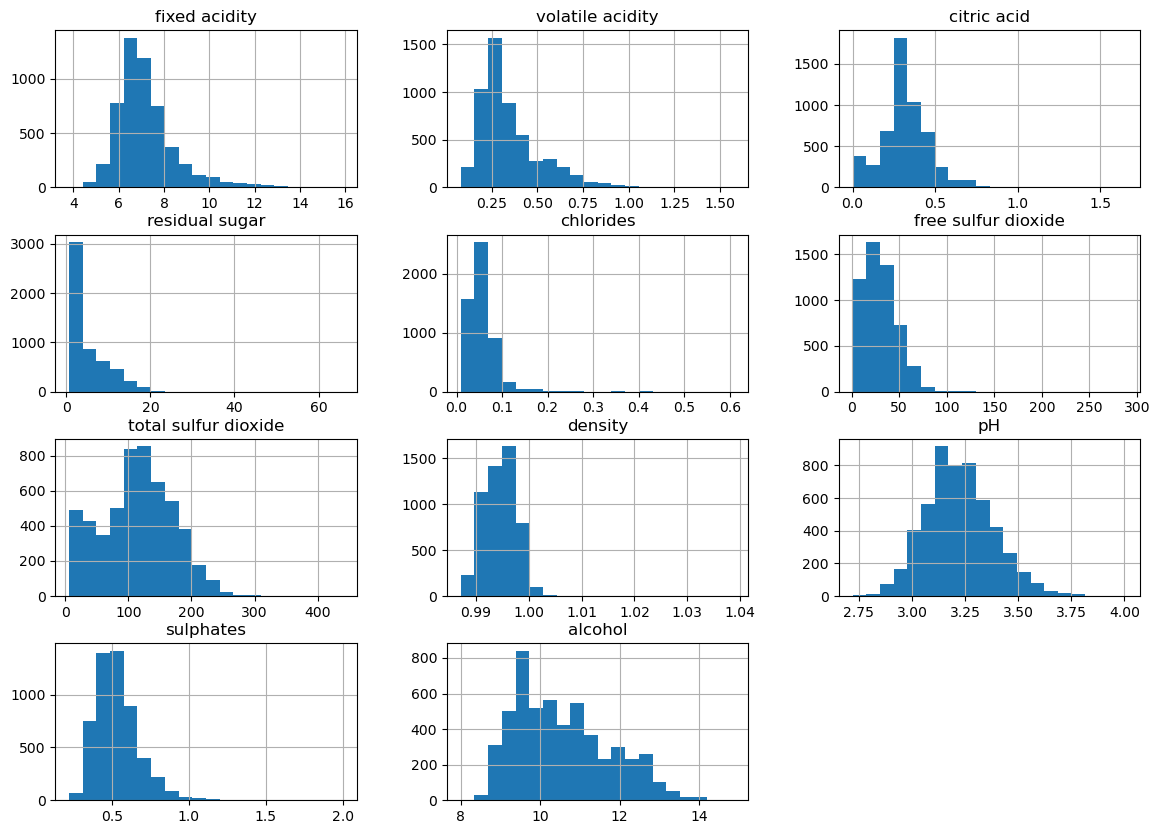

In [149]:
df.hist(bins=20, figsize=(14, 10))
plt.show()

**Based on these results, we believe scaling is necessary** because the features have different ranges. For example, fixed acidity ranges from 4.6 to 15.9, while density ranges from 0.99007 to 1.00369. Additionally, the means and standard deviations of the features also vary significantly. Moreover, some features, such as residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, and sulphates, are skewed.

**As a result, we will perform scaling after splitting the data into training and testing sets.** Doing this beforehand may lead to data leakage, where information from the test set influences the training set. 

**Note: We only will apply scaling to models that benefit from the effect (logistic regression, kNN, and Boosting).**

Otherwise, our code is ready for modeling! The code below exports df into a csv file after the pre-processing steps. 

In [152]:
df.to_csv('WineDataFinal.csv', index = False) # Comment out if not needed!

# Modeling

First, we define our features and target variable, split the data into training and testing sets, and apply scaling/standardization to our predictors. 

Here, we are scaling to zero mean and unit variance. So, each feature will have a mean of 0 and a standard deviation of 1. For each feature (column), the values are transformed using the formula: z = x−μ / σ , where x is the original value, μ is the mean of the feature, and σ is the standard deviation of the feature.

As a result, each element in the scaled arrays of the training and testing data is the stanardized value of the corresponding feature. For example, the value -0.66268263 in the first row and first column means that the original value of the first feature in the first sample is 0.662 standard deviations below the mean of that feature. Otherwise, it has the same shape as the original training and testing data. 

In [155]:
X = df.drop(columns = ['color_white'])
#X = df.drop(columns = ['color_white','citric acid', 'pH'])
y = df['color_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.33, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Additionally, before modeling, we created a correlation matrix to see if there is any significant potential for multicollinearity. Since none of the variables correlate > 0.8, we believe there is no need to remove predictors at this time.

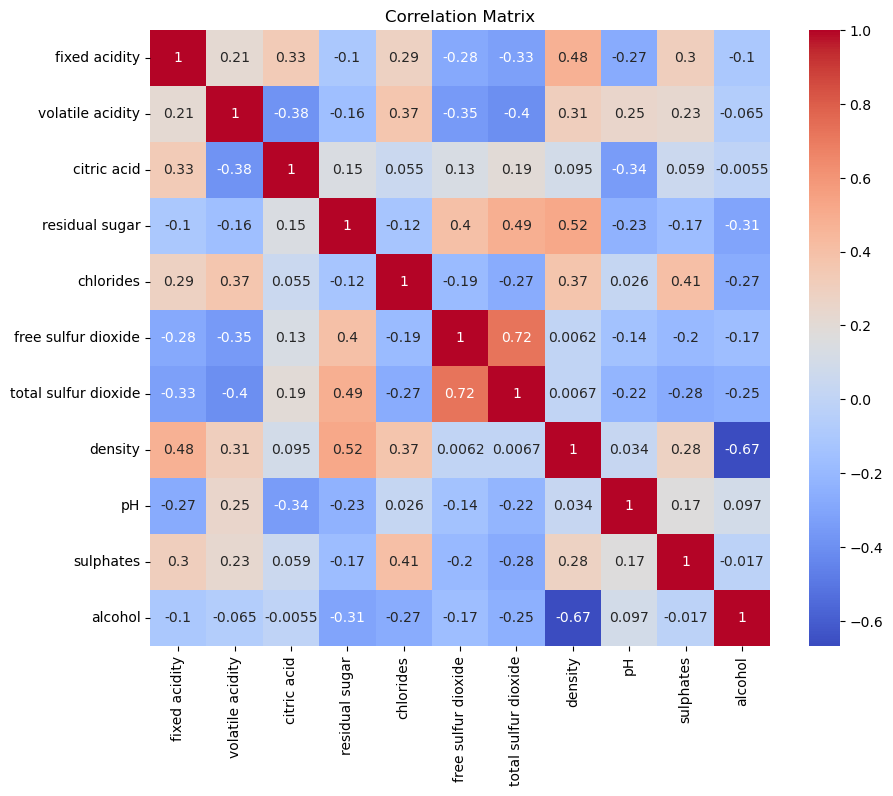

In [157]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Logistic Regression - Andrew

In [159]:
lg_best = LogisticRegression(random_state = 22)
lg_best.fit(X_train_scaled, y_train)

LogisticRegression(random_state=22)

Model: Logistic Regression
Accuracy: 0.9937357630979499
ROC AUC: 0.9980897786971984
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99       449
        True       1.00      0.99      1.00      1307

    accuracy                           0.99      1756
   macro avg       0.99      0.99      0.99      1756
weighted avg       0.99      0.99      0.99      1756

Cohen's Kappa: 0.9835784605444374
Log Loss: 0.030299752393064493


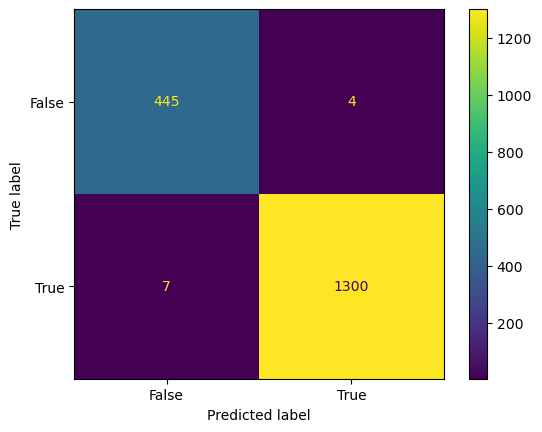

TPR: 0.9946442234123948
FPR: 0.008908685968819599
TNR: 0.9910913140311804
FNR: 0.005355776587605203


In [160]:
y_pred = lg_best.predict(X_test_scaled)
y_proba = lg_best.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lg_best.classes_)

print(f"Model: Logistic Regression")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

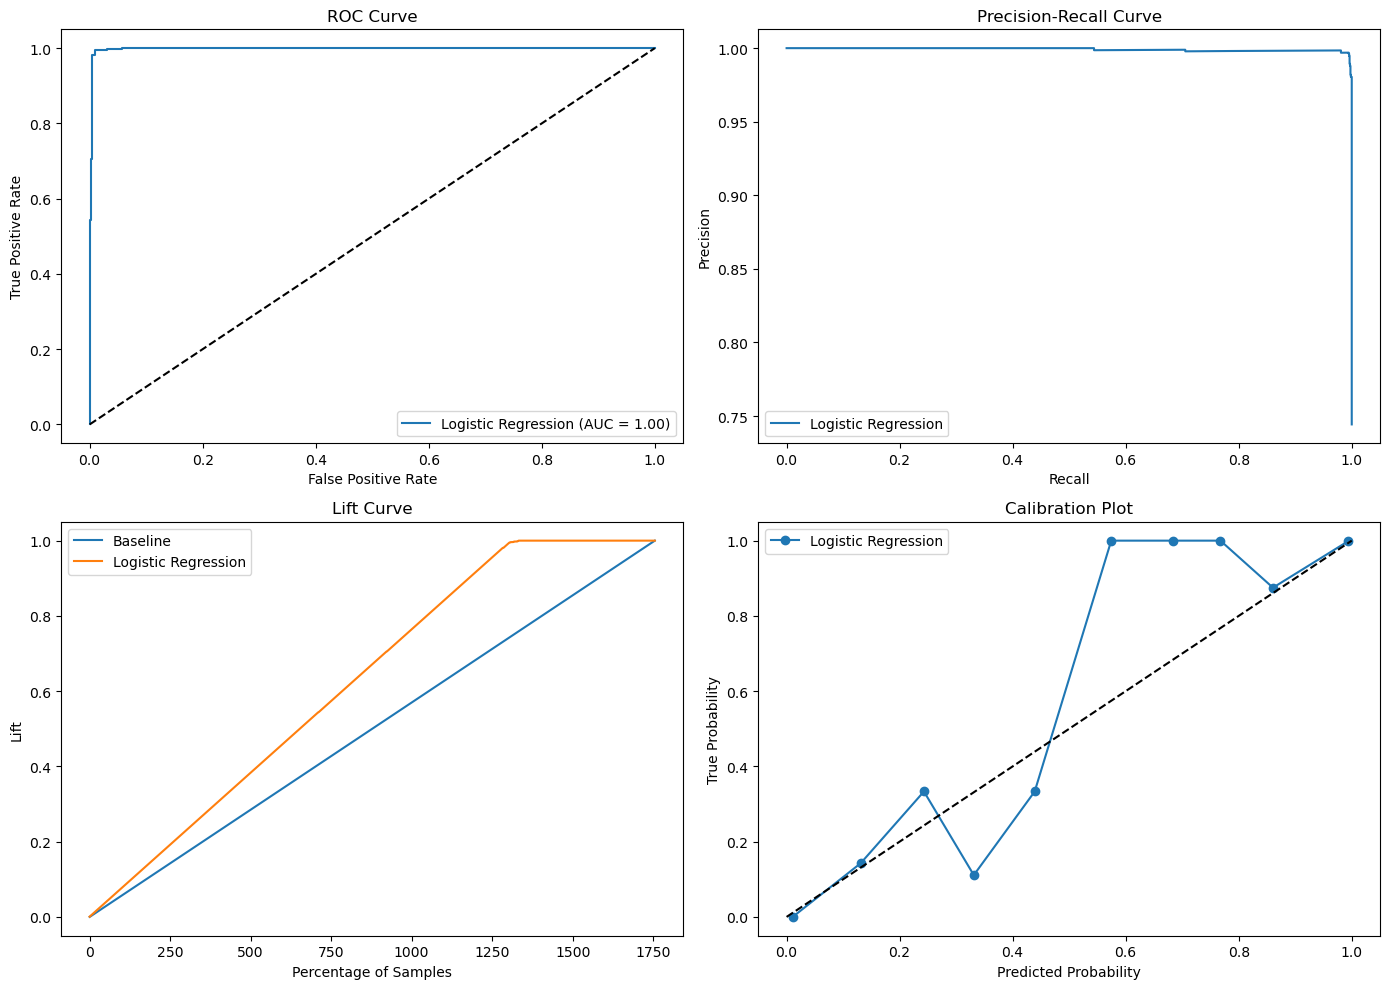

In [161]:
def plot_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"Logistic Regression")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"Logistic Regression")
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"Logistic Regression")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_proba)

                 Feature  Coefficient  Importance
7                density    -2.764638    2.764638
3         residual sugar     2.643065    2.643065
6   total sulfur dioxide     2.404079    2.404079
1       volatile acidity    -1.182838    1.182838
4              chlorides    -1.028706    1.028706
10               alcohol    -0.972668    0.972668
9              sulphates    -0.818900    0.818900
5    free sulfur dioxide    -0.668307    0.668307
0          fixed acidity    -0.645365    0.645365
8                     pH    -0.525080    0.525080
2            citric acid     0.356728    0.356728


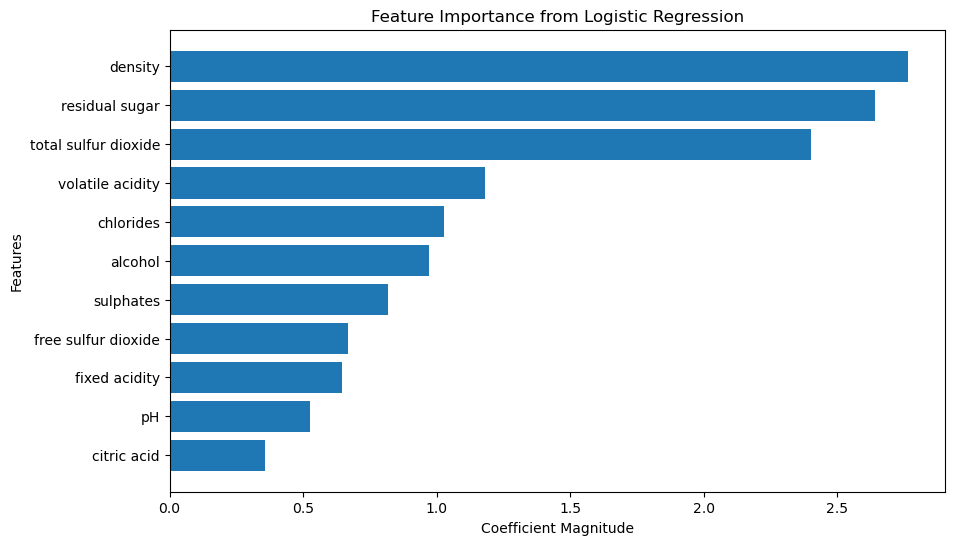

In [162]:
coefficients = lg_best.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

feature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## Decision Tree Classification - Akash

In [164]:
dt_best = DecisionTreeClassifier(random_state = 22, max_depth = 4)
dt_best.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=22)

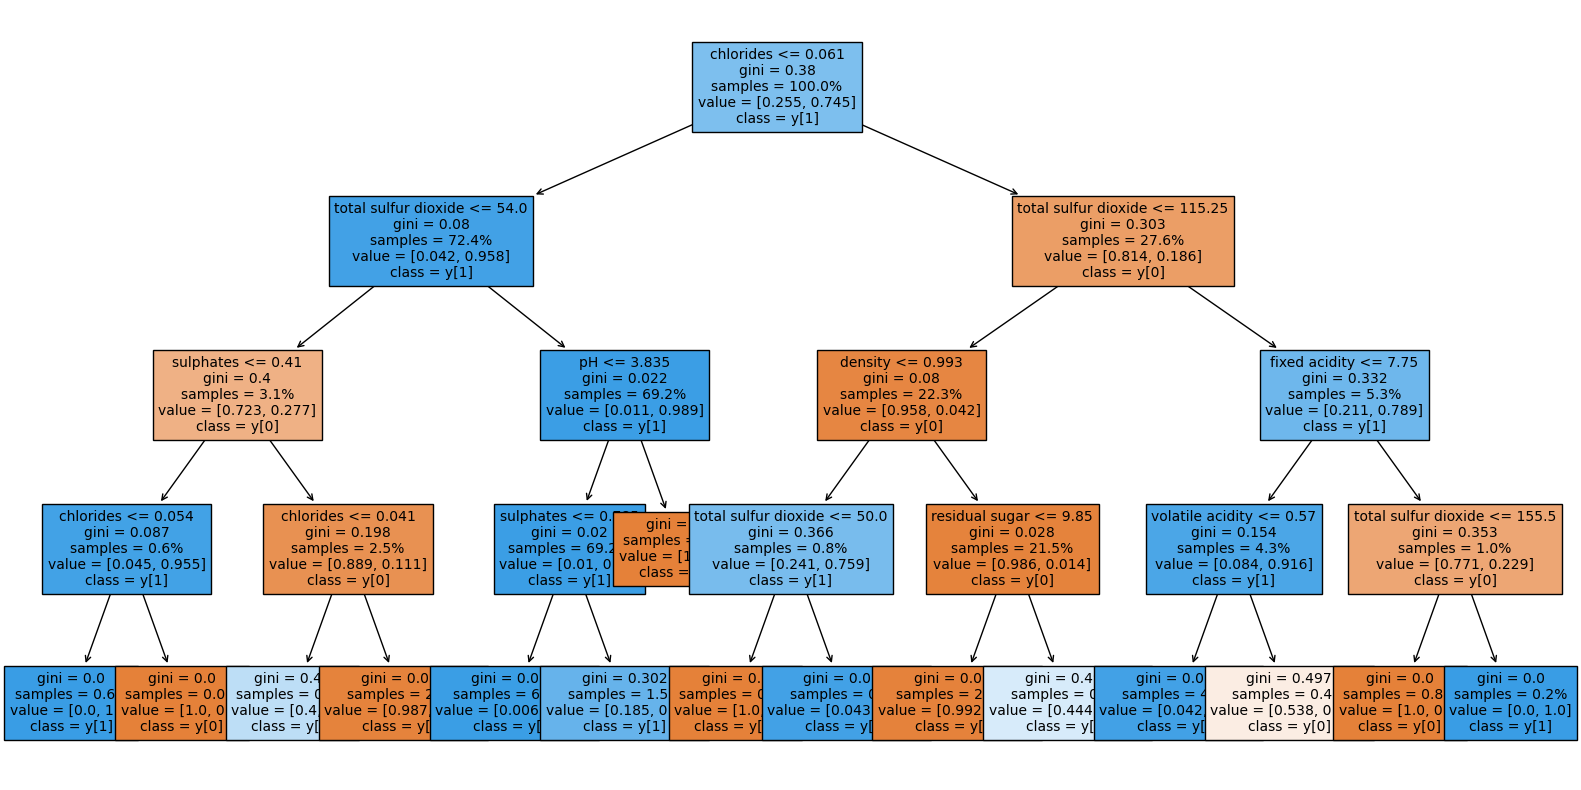

In [165]:
plt.figure(figsize=(20, 10))

plot_tree(
    dt_best, 
    filled=True, 
    feature_names=X_train.columns, 
    class_names=True, 
    fontsize=10, 
    proportion=True 
)

plt.show()

Model: Decision Tree
Accuracy: 0.9829157175398633
ROC AUC: 0.9836864374287502
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       449
        True       0.99      0.99      0.99      1307

    accuracy                           0.98      1756
   macro avg       0.98      0.98      0.98      1756
weighted avg       0.98      0.98      0.98      1756

Cohen's Kappa: 0.9549180257723754
Log Loss: 0.07330965600409697


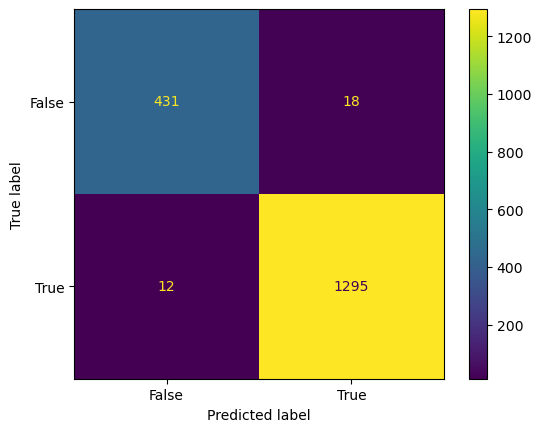

TPR: 0.9908186687069626
FPR: 0.0400890868596882
TNR: 0.9599109131403119
FNR: 0.009181331293037491


In [166]:
y_pred = dt_best.predict(X_test)
y_proba = dt_best.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_best.classes_)

print(f"Model: Decision Tree")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

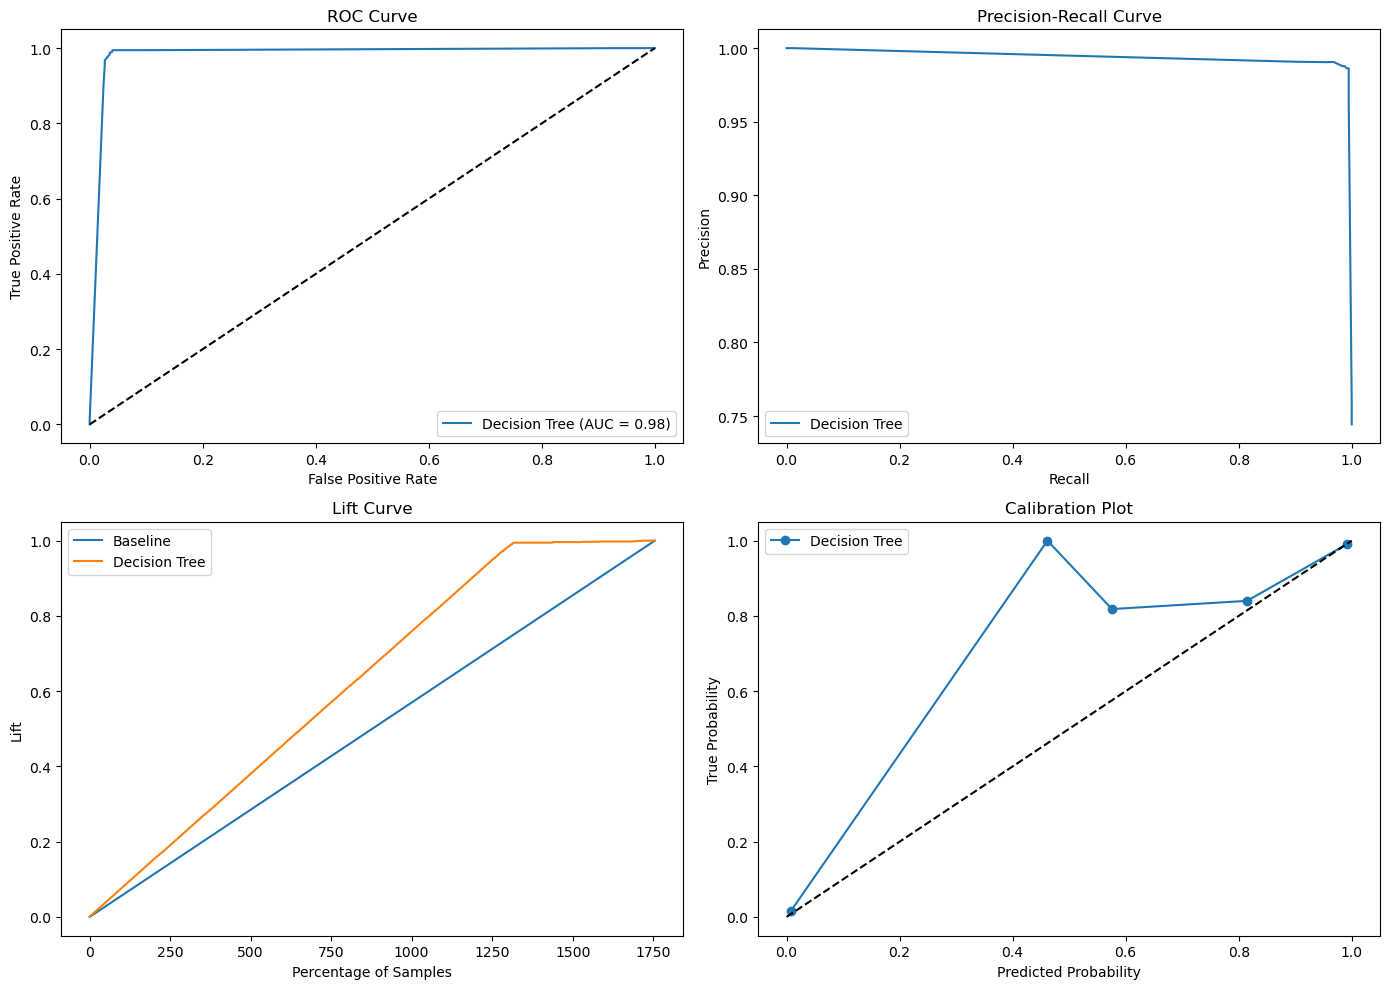

In [167]:
def plot_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"Decision Tree")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"Decision Tree")
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"Decision Tree")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_proba)

                      Importance
chlorides               0.681165
total sulfur dioxide    0.238441
density                 0.024494
sulphates               0.022579
fixed acidity           0.021361
volatile acidity        0.004641
residual sugar          0.004221
pH                      0.003099
citric acid             0.000000
free sulfur dioxide     0.000000
alcohol                 0.000000


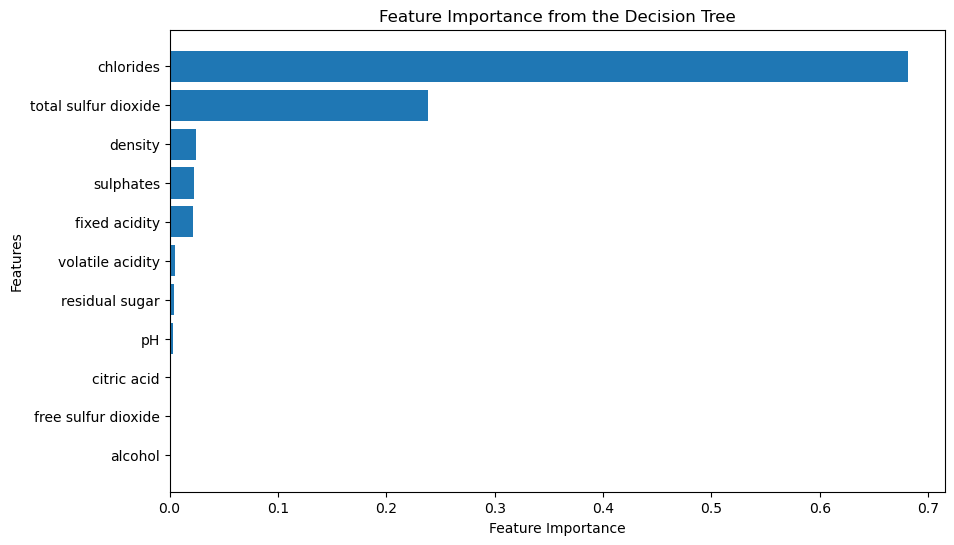

In [168]:
if hasattr(dt_best, 'feature_importances_'):
    feature_importance = pd.DataFrame(dt_best.feature_importances_, index=X.columns, columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.index, feature_importance['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance from the Decision Tree')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print(f"The Decision Tree does not have feature importances attribute.")

## Bagging Classification - Agnitra

In [170]:
best_bg = BaggingClassifier(estimator = DecisionTreeClassifier(random_state = 22), n_estimators = 345, random_state = 22)
best_bg.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=22),
                  n_estimators=345, random_state=22)

Model: Bagging
Accuracy: 0.9943052391799544
ROC AUC: 0.9954809037510884
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       449
        True       1.00      1.00      1.00      1307

    accuracy                           0.99      1756
   macro avg       0.99      0.99      0.99      1756
weighted avg       0.99      0.99      0.99      1756

Cohen's Kappa: 0.9850166813143681
Log Loss: 0.0891946325360075


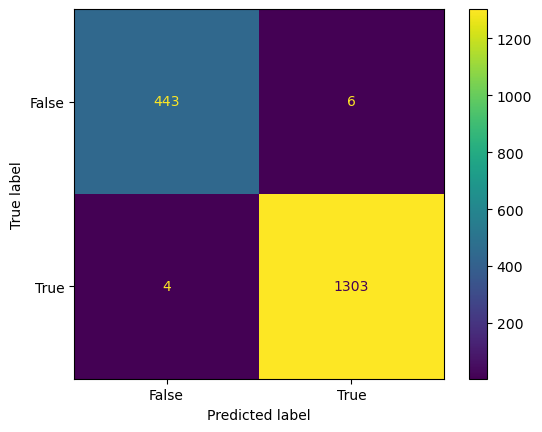

TPR: 0.9969395562356542
FPR: 0.013363028953229399
TNR: 0.9866369710467706
FNR: 0.00306044376434583


In [171]:
y_pred = best_bg.predict(X_test)
y_proba = best_bg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_bg.classes_)

print(f"Model: Bagging")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

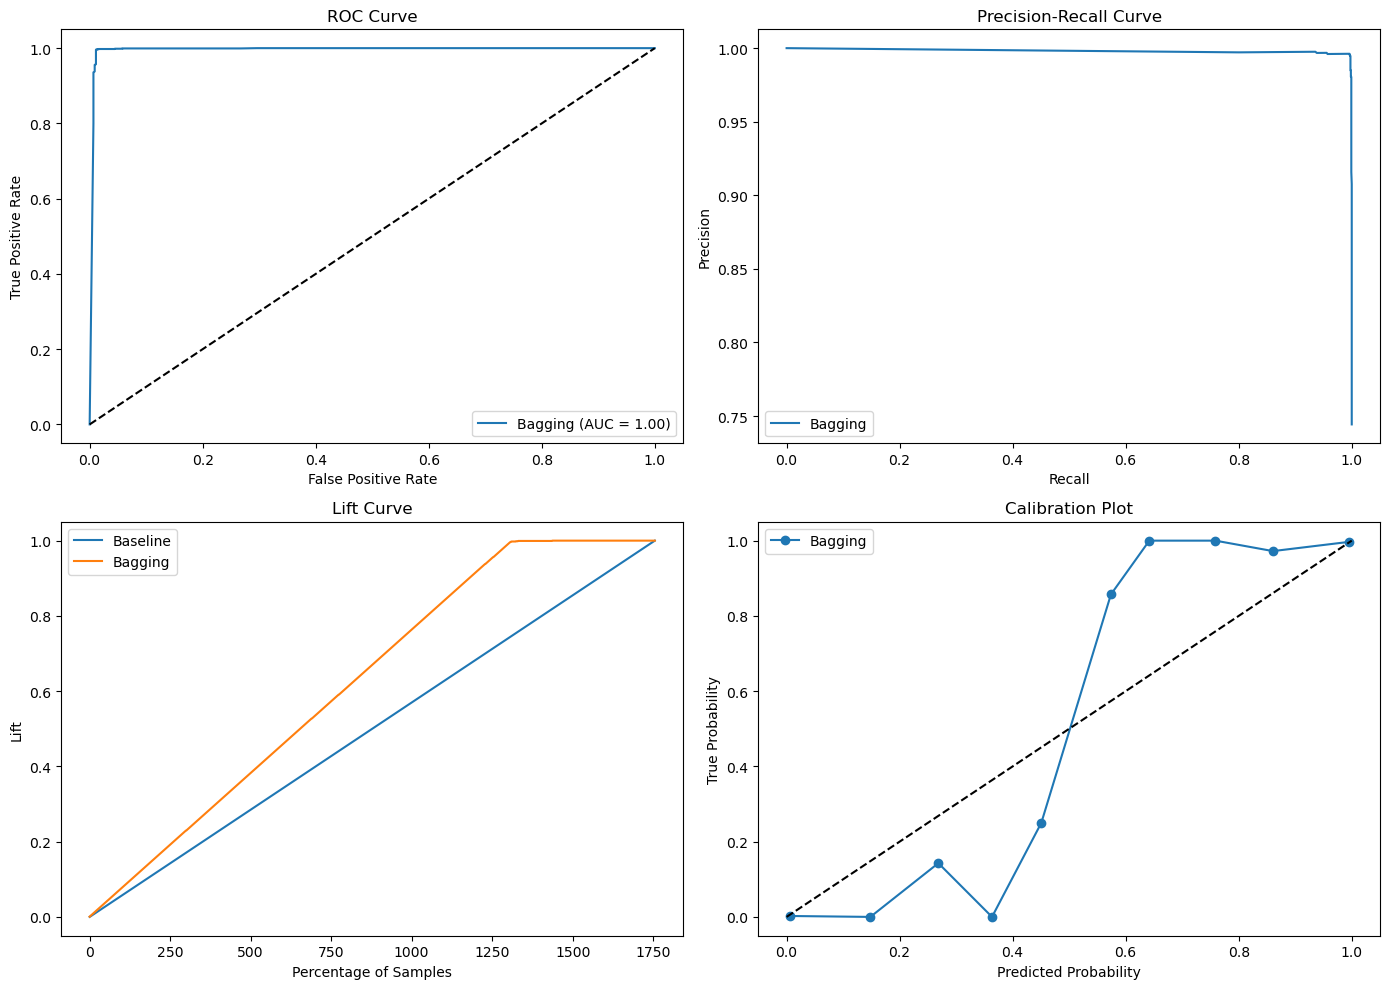

In [172]:
def plot_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"Bagging (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"Bagging")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"Bagging")
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"Bagging")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_proba)

                      Importance
total sulfur dioxide    0.454596
chlorides               0.420128
density                 0.027478
volatile acidity        0.027037
sulphates               0.019721
fixed acidity           0.014226
pH                      0.012273
residual sugar          0.010516
alcohol                 0.007902
citric acid             0.003726
free sulfur dioxide     0.002396


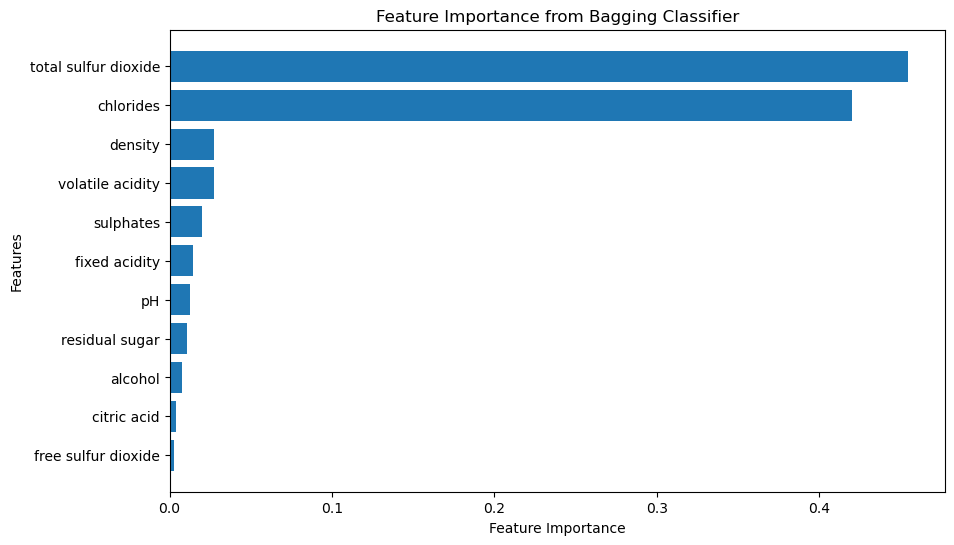

In [173]:
if hasattr(best_bg.estimators_[0], 'feature_importances_'):
    feature_importances = np.mean([
        tree.feature_importances_ for tree in best_bg.estimators_
    ], axis=0)

    feature_importance_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=['Importance'])
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df.index, feature_importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance from Bagging Classifier')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("The base estimator does not have feature importances attribute.")

## Random Forest Classification - Agnitra

In [175]:
best_rf = RandomForestClassifier(n_estimators = 345, max_features=6, random_state = 22)
best_rf.fit(X_train,y_train)

RandomForestClassifier(max_features=6, n_estimators=345, random_state=22)

Model: Random Forest
Accuracy: 0.994874715261959
ROC AUC: 0.9966711709946272
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       449
        True       1.00      1.00      1.00      1307

    accuracy                           0.99      1756
   macro avg       0.99      0.99      0.99      1756
weighted avg       0.99      0.99      0.99      1756

Cohen's Kappa: 0.9865051335824413
Log Loss: 0.06909697415833599


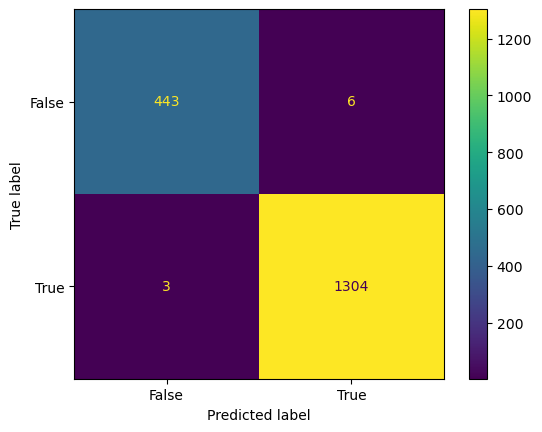

TPR: 0.9977046671767407
FPR: 0.013363028953229399
TNR: 0.9866369710467706
FNR: 0.0022953328232593728


In [176]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_)

print(f"Model: Random Forest")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

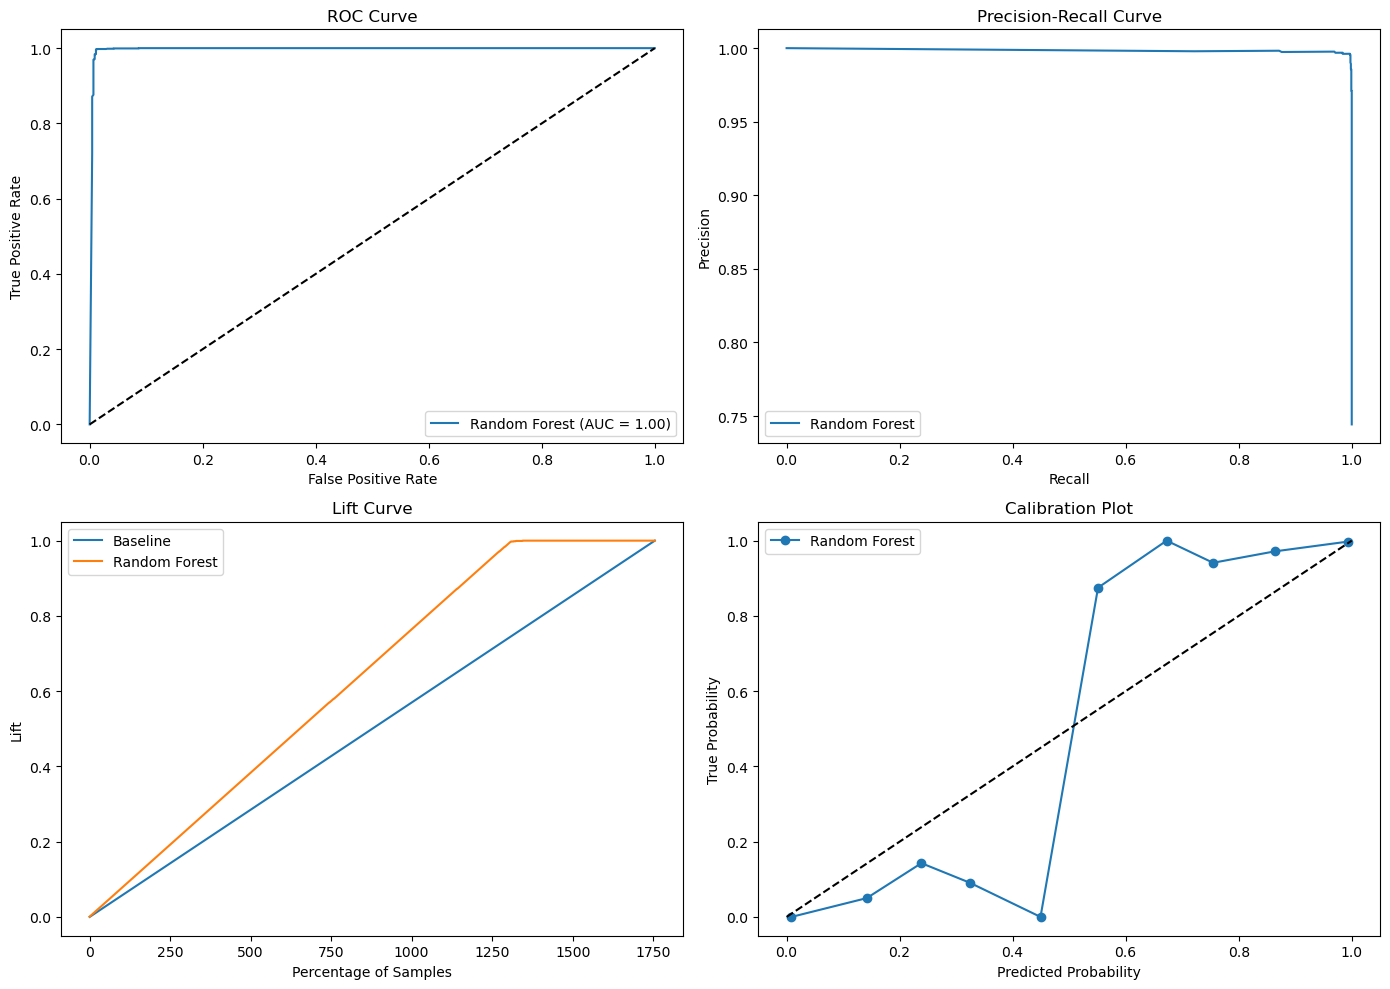

In [177]:
def plot_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"Random Forest")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"Random Forest")
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"Random Forest")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_proba)

                      Importance
total sulfur dioxide    0.409185
chlorides               0.346254
volatile acidity        0.083695
density                 0.038860
sulphates               0.025921
free sulfur dioxide     0.024643
residual sugar          0.023893
fixed acidity           0.017873
pH                      0.014687
alcohol                 0.008229
citric acid             0.006760


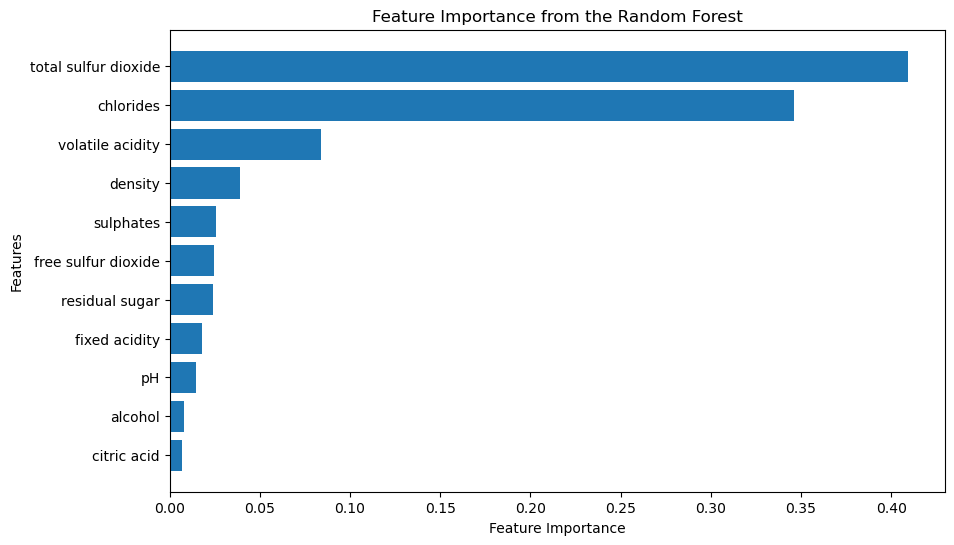

In [178]:
if hasattr(best_rf, 'feature_importances_'):
    feature_importance = pd.DataFrame(best_rf.feature_importances_, index=X.columns, columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.index, feature_importance['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance from the Random Forest')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print(f"The Random Forest does not have feature importances attribute.")

## KNN Classification - Ethan

In [180]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]
}

knn = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC: {grid_search.best_score_}")

Best parameters: {'n_neighbors': 25}
Best ROC AUC: 0.9957441473266412


Model: KNN
Accuracy: 0.9920273348519362
ROC AUC: 0.9972462822253993
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       449
        True       1.00      0.99      0.99      1307

    accuracy                           0.99      1756
   macro avg       0.99      0.99      0.99      1756
weighted avg       0.99      0.99      0.99      1756

Cohen's Kappa: 0.9790846025444911
Log Loss: 0.06510617906172979


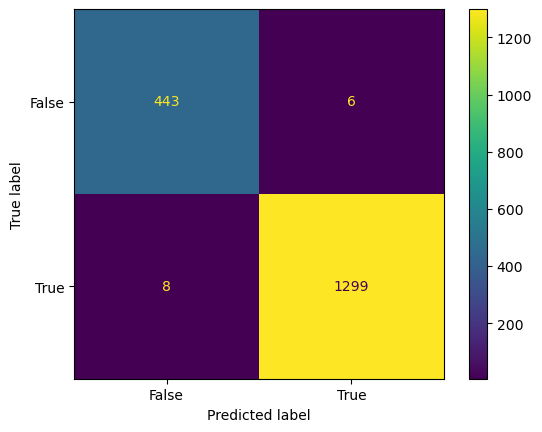

TPR: 0.9938791124713083
FPR: 0.013363028953229399
TNR: 0.9866369710467706
FNR: 0.00612088752869166


In [181]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)

print(f"Model: KNN")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

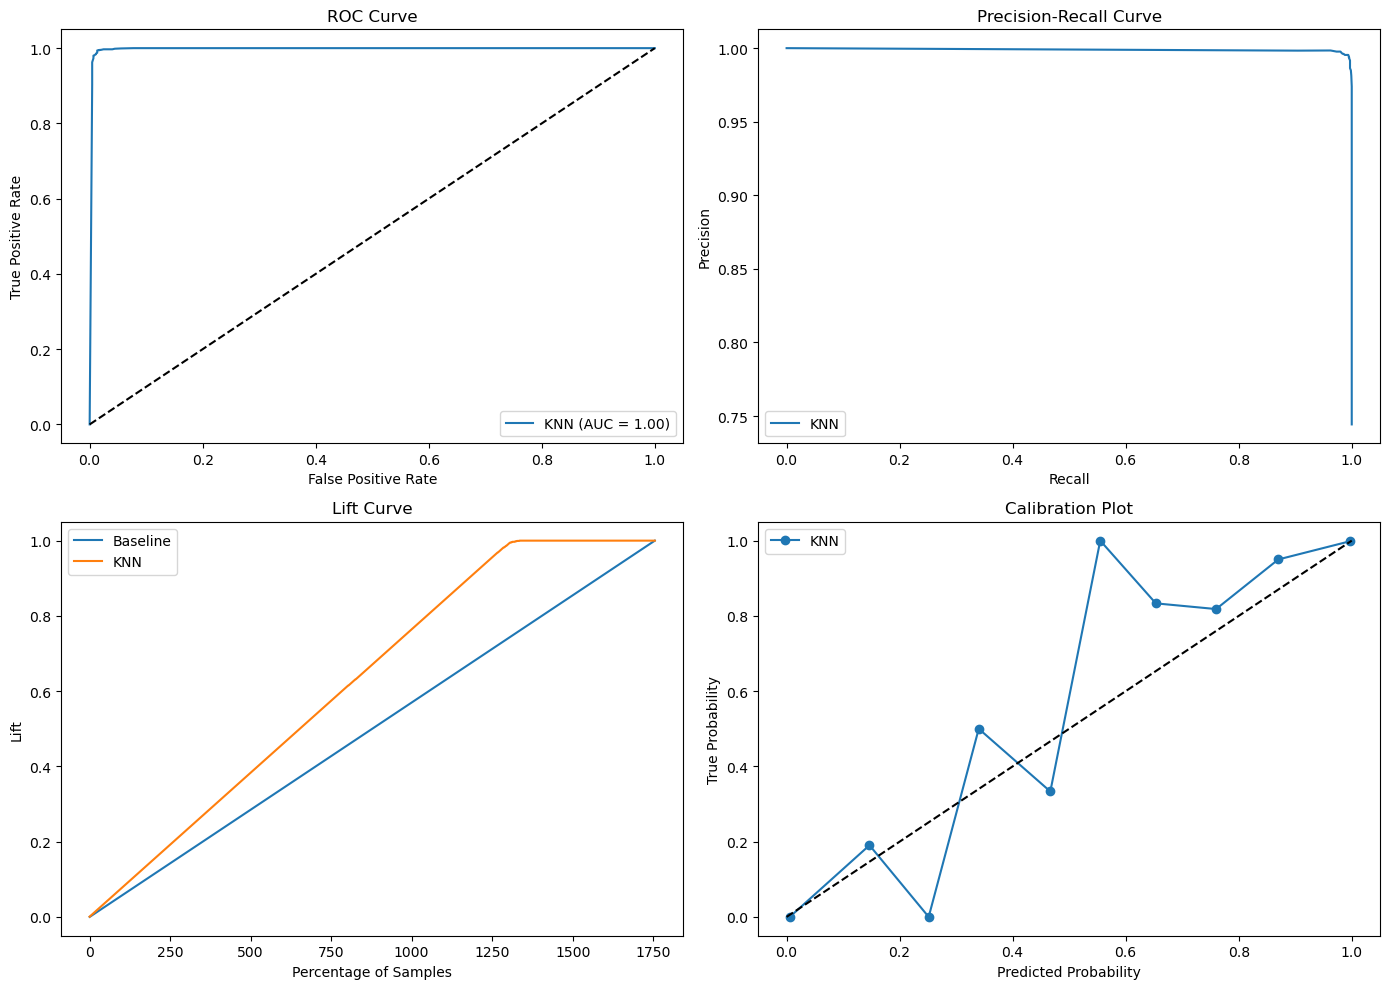

In [182]:
def plot_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"KNN (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"KNN")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"KNN")
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"KNN")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_proba)

## Boosting Classification - Ethan

In [184]:
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

models = {
    'AdaBoost': AdaBoostClassifier(random_state = 22, algorithm="SAMME"),
    'GradientBoosting': GradientBoostingClassifier(random_state = 22),
    'XGBoost': XGBClassifier(random_state = 22, eval_metric = 'logloss')
}

best_estimators = {}
best_model_name = None
best_roc_auc = -np.inf

for model_name in models.keys():
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=StratifiedKFold(10), 
                               scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best ROC AUC for {model_name}: {grid_search.best_score_}")
    
    if grid_search.best_score_ > best_roc_auc:
        best_roc_auc = grid_search.best_score_
        best_model_name = model_name

print(f"\nBest model: {best_model_name} with ROC AUC: {best_roc_auc}")

Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
Best ROC AUC for AdaBoost: 0.9988779641411221
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best ROC AUC for GradientBoosting: 0.9990678905432772
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best ROC AUC for XGBoost: 0.9992305665677774

Best model: XGBoost with ROC AUC: 0.9992305665677774


Model: XGBoost
Accuracy: 0.9954441913439636
ROC AUC: 0.9970426502488741
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       449
        True       1.00      1.00      1.00      1307

    accuracy                           1.00      1756
   macro avg       0.99      0.99      0.99      1756
weighted avg       1.00      1.00      1.00      1756

Cohen's Kappa: 0.9880483443111379
Log Loss: 0.02173429255995678


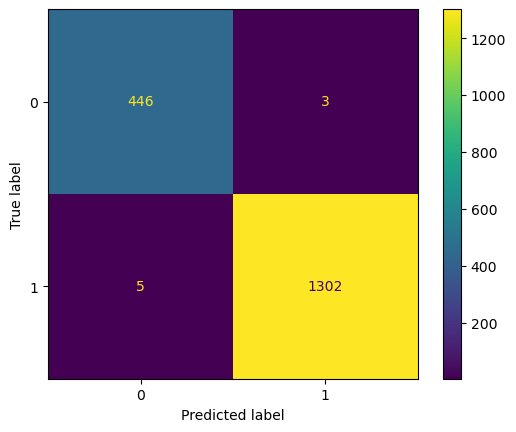

TPR: 0.9961744452945677
FPR: 0.0066815144766146995
TNR: 0.9933184855233853
FNR: 0.0038255547054322878


In [185]:
best_model = best_estimators[best_model_name]
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
class_report = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)

print(f"Model: {best_model_name}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Classification Report:\n{class_report}")
print(f"Cohen's Kappa: {kappa}")
print(f"Log Loss: {logloss}")
disp.plot()
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}")

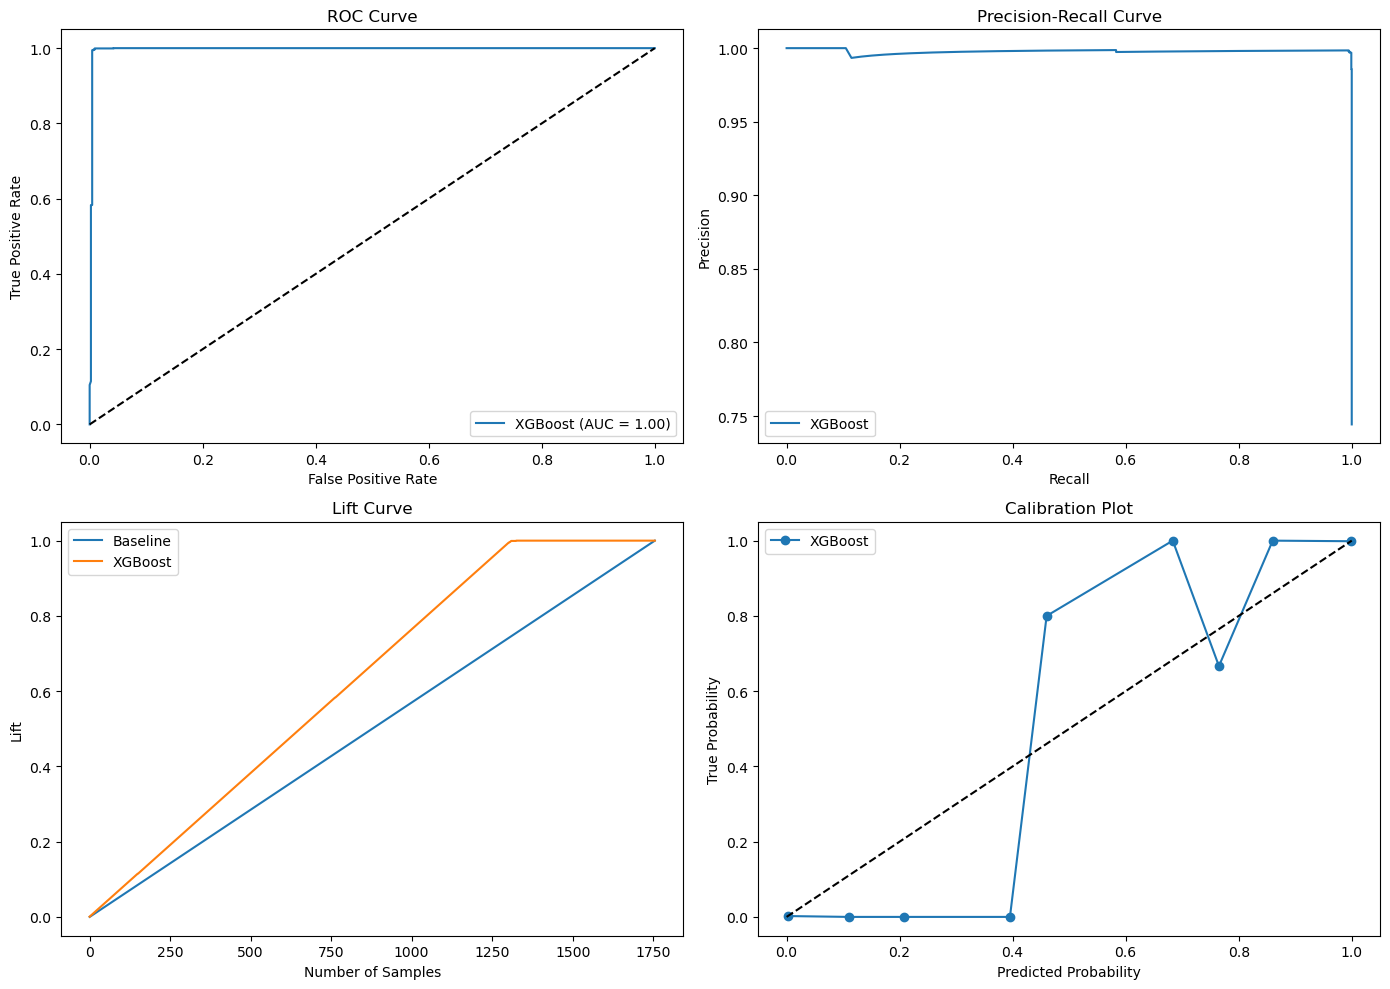

In [186]:
def plot_metrics(model_name, y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.subplot(2, 2, 3)
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y_test = y_test.values[sorted_indices]
    lift = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    baseline = np.linspace(0, 1, len(sorted_y_test))
    plt.plot(baseline, label="Baseline")
    plt.plot(lift, label=f"{model_name}")
    plt.xlabel('Number of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend(loc="upper left")

    plt.subplot(2, 2, 4)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f"{model_name}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Plot')
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_metrics(best_model_name, y_test, y_proba)

The ROC Curve and high precision-recall values indicate that the model is performing exceptionally well on the data set, likely due to the clear separation of classes base on predictors. Additionally, the lift curve demonstrates that the model is very effective at ranking predictions, meaning it successfully identifies the most likely positive cases. However, the calibration plot suggests that there may be some room for improving the predicted probability estimates to more closely match the observed outcomes.


                      Importance
chlorides               0.438681
total sulfur dioxide    0.321545
volatile acidity        0.063111
sulphates               0.046393
density                 0.031309
pH                      0.030270
fixed acidity           0.023336
alcohol                 0.015045
residual sugar          0.013827
citric acid             0.011084
free sulfur dioxide     0.005399


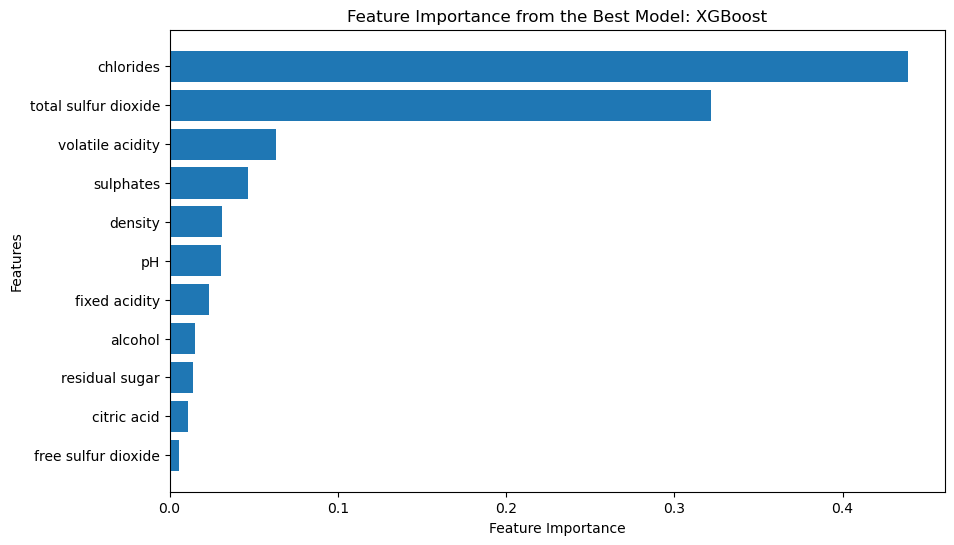

In [188]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.index, feature_importance['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance from the Best Model: {best_model_name}')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print(f"The best model ({best_model_name}) does not have feature importances attribute.")

These results are extremely promising - almost too promising. To investigate, I wanted to plot the distribution of the top features by wine color and perform a principal component analysis to see if there is a good separation between white and non-white (red) wines.

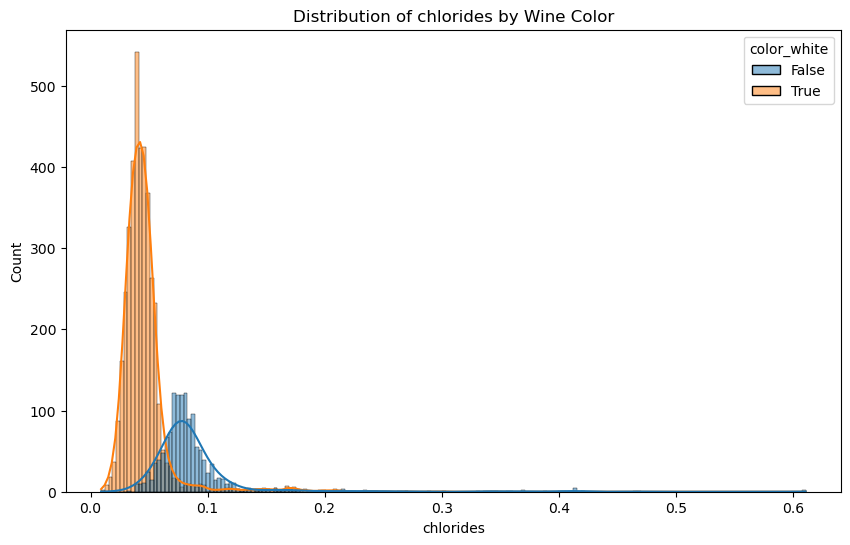

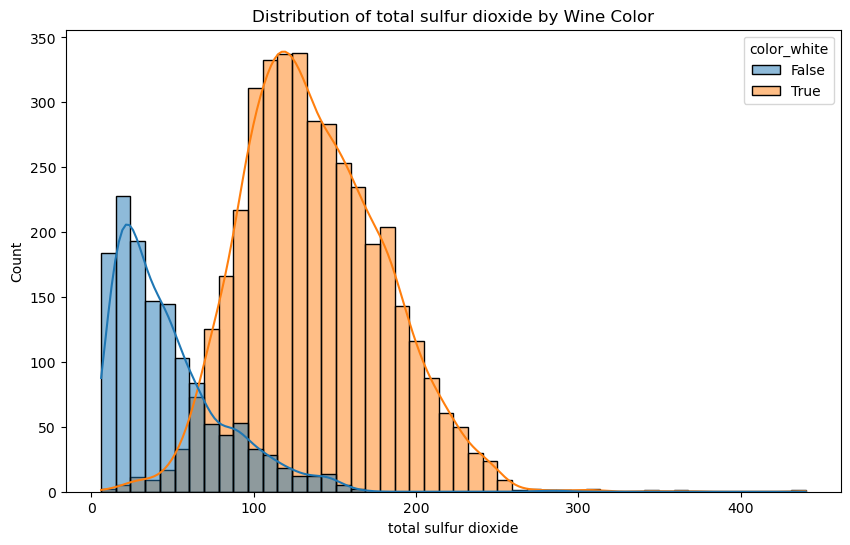

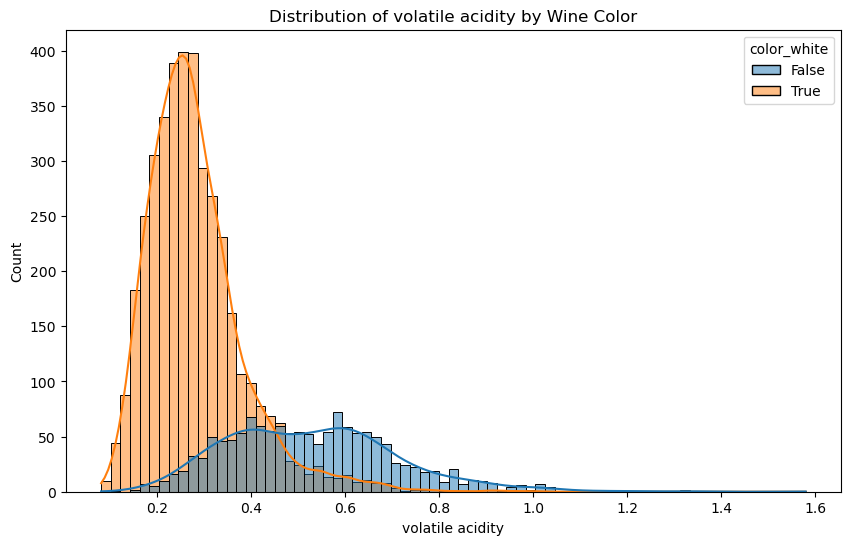

In [190]:
top_features = ['chlorides', 'total sulfur dioxide', 'volatile acidity']

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue='color_white', kde=True)
    plt.title(f'Distribution of {feature} by Wine Color')
    plt.show()

Based on the above plots, these distributions confirm that these features are good predictors for distinguishing between white and non-white (red) wines.

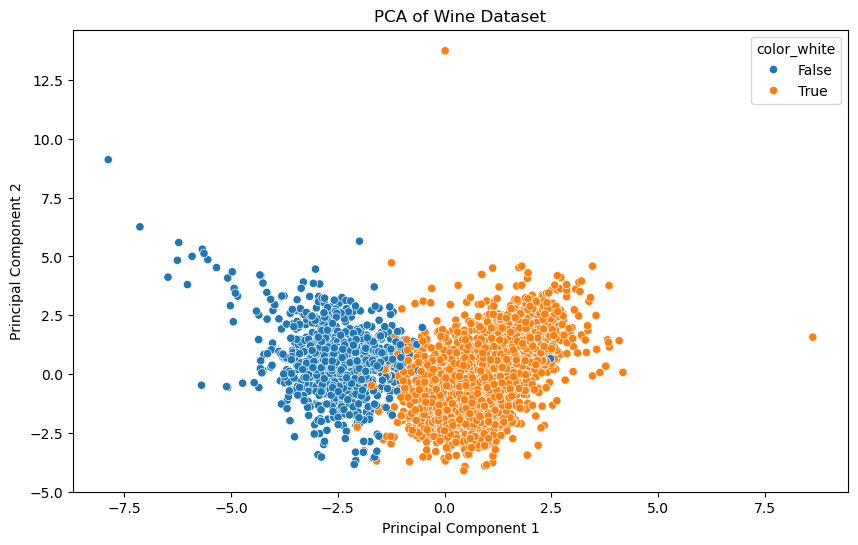

In [192]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)
plt.title('PCA of Wine Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The PCA plot shows a good separation between white and non-white wines using the first two principal components. This indicates that the model's feature space is well-separated.

# Feature Selection / Engineering

In [195]:
# Feature selection using SelectKBest and mutual information
selector = SelectKBest(mutual_info_classif, k='all').fit(X, y)
scores = selector.scores_

feature_names = list(X.columns)

for i, score in enumerate(selector.scores_):
    print("Feature %s: %f" % (feature_names[i], score))

selected_features_indices = selector.get_support(indices=True)

score_dict = dict(zip(feature_names, scores))
sorted_dict = sorted(score_dict.items(), key=lambda x: x[1])

# Baseline model cross-validation score
baseline_model = XGBClassifier(random_state=22, learning_rate=0.1, max_depth=3, n_estimators=200)
baseline_cv_score = cross_val_score(baseline_model, X_train_scaled, y_train, scoring='roc_auc', cv=10).mean()
print('Baseline Cross Validation ROC AUC:', round(baseline_cv_score * 100, 2), '%')

# List to hold features that should be removed
features_to_remove = []

for feature, _ in sorted_dict:
    # Drop one feature at a time
    X_temp = X_train.drop(columns=[feature])

    # Scale the temporary dataset
    X_temp_scaled = scaler.fit_transform(X_temp)

    # Construct a new model with the removed feature
    model_temp = XGBClassifier(random_state=22, learning_rate=0.1, max_depth=3, n_estimators=200)

    # Calculate the 10-Fold Cross Validation ROC AUC % on the new model
    auc_score = cross_val_score(model_temp, X_temp_scaled, y_train, scoring='roc_auc', cv=10).mean()

    print('Cross Validation ROC AUC after removing', feature, ':', round(auc_score * 100, 2), '%')

    if auc_score >= baseline_cv_score:
        features_to_remove.append(feature)

print('\nFeatures to Remove:', features_to_remove)

Feature fixed acidity: 0.131177
Feature volatile acidity: 0.229720
Feature citric acid: 0.101276
Feature residual sugar: 0.196094
Feature chlorides: 0.351720
Feature free sulfur dioxide: 0.157064
Feature total sulfur dioxide: 0.346717
Feature density: 0.141540
Feature pH: 0.055143
Feature sulphates: 0.146759
Feature alcohol: 0.020023
Baseline Cross Validation ROC AUC: 99.92 %
Cross Validation ROC AUC after removing alcohol : 99.84 %
Cross Validation ROC AUC after removing pH : 99.92 %
Cross Validation ROC AUC after removing citric acid : 99.92 %
Cross Validation ROC AUC after removing fixed acidity : 99.92 %
Cross Validation ROC AUC after removing density : 99.88 %
Cross Validation ROC AUC after removing sulphates : 99.91 %
Cross Validation ROC AUC after removing free sulfur dioxide : 99.91 %
Cross Validation ROC AUC after removing residual sugar : 99.9 %
Cross Validation ROC AUC after removing volatile acidity : 99.92 %
Cross Validation ROC AUC after removing total sulfur dioxide : 99